## Introduction

In order to start teaching myself data science and Python, I decided to work with a data set near and dear to my heart. Magic cards are an ideal data set to study for several reasons - there are a large number of observations (over 10,000 cards and nearly 200 sets released) while still being fairly tractable. There are a variety of interesting characteristics, both numerical and qualitative, to analyze. Most importantly, a number of relevant questions about the design and development of Magic cards can be explored with methods in statistical learning, such as:

* Have creatures gotten more powerful over the years?
* Has removal gotten worse?
* Given the text of a card, is it possible to predict its color and mana cost?

This notebook will document my process of working with this data set to produce answers to questions like these. I'm still a beginner, so this will be as much about documenting mistakes I make and issues I encounter as it will be about any insights I may discover. Any feedback is appreciated.

## Data Extraction

Before doing any analysis, I need to process the data the make it easy to work with in Python. My first task is to convert `all_sets.json` into a pandas DataFrame using the `read_json` method:

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

AllSets-x.json



In [2]:
# read sets into a DataFrame; index is chosen as the orient so the set names are the indices
all_sets = pd.read_json("../input/AllSets-x.json", orient = "index")
all_sets.head()

,block,booster,border,cards,code,gathererCode,magicCardsInfoCode,magicRaritiesCodes,mkm_id,mkm_name,name,oldCode,onlineOnly,releaseDate,translations,type
10E,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",black,"[{'artist': 'Pete Venters', 'cmc': 7, 'colorId...",10E,NaN,10e,NaN,74.0,Tenth Edition,Tenth Edition,NaN,NaN,2007-07-13,"{'de': 'Zehnte Edition', 'fr': 'Dixième éditio...",core
2ED,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",white,"[{'artist': 'Richard Thomas', 'cmc': 5, 'color...",2ED,2U,un,NaN,3.0,Unlimited,Unlimited Edition,NaN,NaN,1993-12-01,NaN,core
3ED,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",white,"[{'artist': 'Richard Thomas', 'cmc': 5, 'color...",3ED,3E,rv,NaN,6.0,Revised,Revised Edition,NaN,NaN,1994-04-01,"{'de': 'Unlimitierte Auflage', 'fr': 'Tirage N...",core
4ED,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",white,"[{'artist': 'Mark Tedin', 'cmc': 5, 'colorIden...",4ED,4E,4e,NaN,10.0,Fourth Edition,Fourth Edition,NaN,NaN,1995-04-01,"{'de': 'Vierte Edition', 'fr': 'Quatrième Edit...",core
5DN,Mirrodin,"[rare, uncommon, uncommon, uncommon, common, c...",black,"[{'artist': 'John Matson', 'cmc': 4, 'colorIde...",5DN,NaN,5dn,NaN,47.0,Fifth Dawn,Fifth Dawn,NaN,NaN,2004-06-04,"{'de': 'Fünfte Morgenröte', 'fr': 'La Cinquièm...",expansion


The `all_sets` DataFrame is a list of all Magic sets (through September 2016) indexed by the set codename. I used the `index` orientation since the structure of the `all_sets.json`, as described by the documentation on the [MTGJSON website]](https://mtgjson.com/documentation.html), is of the form

`{
    ...
    set_code1 : { /* set data /* },
    set_code2 : { /* set data /* },
    set_code3 : { /* set data /* },
    ...
}`

which is of the form `{index -> {column -> value}}` described in the [pandas documentation for the `read_json` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html#pandas.read_json). We can now examine some basic characteristics of `all_sets`:

In [3]:
# the set names are the indices, and the columns are the attributes of each set (border, cards, etc)
all_sets.shape

(199, 16)

In [4]:
all_sets.columns

Index(['block', 'booster', 'border', 'cards', 'code', 'gathererCode',
       'magicCardsInfoCode', 'magicRaritiesCodes', 'mkm_id', 'mkm_name',
       'name', 'oldCode', 'onlineOnly', 'releaseDate', 'translations', 'type'],
      dtype='object')

In [5]:
all_sets.describe()

,mkm_id,onlineOnly
count,113.000000,6.0
mean,525.451327,1.0
std,658.301019,0.0
min,1.000000,1.0
25%,36.000000,1.0
50%,91.000000,1.0
75%,1327.000000,1.0
max,1679.000000,1.0


The `describe` method doesn't provide much useful information here, since so far, the only numeric columns of `all_sets` are the set's id number on the Magic vendor [MagicCardMarket](https://www.cardmarket.com/en/Magic), and a column indicating whether or not the set is only available online. The bulk of the useful data in this DataFrame is contained in the `cards` column, which holds a JSON object containing all the cards in each set. We can convert each element of the `cards` column into a pandas DataFrame using the `json` library in Python and `read_json`:

In [6]:
# the cards column contains the cards of each set in json format, so each set of cards can be
# converted from a json object into a DataFrame
all_sets.cards = all_sets.cards.apply(lambda x: pd.read_json(json.dumps(x), orient = "records"))

In [7]:
all_sets.cards["RAV"].head()

,artist,cmc,colorIdentity,colors,flavor,foreignNames,id,imageName,layout,legalities,...,rarity,rulings,subtypes,supertypes,text,toughness,type,types,variations,watermark
0,Jeff Miracola,6.0,[W],[White],NaN,"[{'language': 'Chinese Simplified', 'name': '灵...",ec7845d3751c94d2c5c6a3bab49d6920c29286d7,auratouched mage,normal,"[{'format': 'Commander', 'legality': 'Legal'},...",...,Uncommon,"[{'date': '2005-10-01', 'text': 'Any Aura card...","[Human, Wizard]",NaN,"When Auratouched Mage enters the battlefield, ...",3,Creature — Human Wizard,[Creature],NaN,NaN
1,Alex Horley-Orlandelli,2.0,[W],[White],"""Truth shines even in darkness. Those who marc...","[{'language': 'Chinese Simplified', 'name': '浸...",5f1147102f0d2a8548c50c28dcd81dd71905611b,bathe in light,normal,"[{'format': 'Commander', 'legality': 'Legal'},...",...,Uncommon,"[{'date': '2005-10-01', 'text': 'The color you...",NaN,NaN,Radiance — Choose a color. Target creature and...,NaN,Instant,[Instant],NaN,Boros
2,Nick Percival,3.0,[W],[White],Although the door is flimsy and the lock pathe...,"[{'language': 'Chinese Simplified', 'name': '善...",edb9e93bd08e835190cecb249eac579fcf2bc192,benevolent ancestor,normal,"[{'format': 'Commander', 'legality': 'Legal'},...",...,Common,NaN,[Spirit],NaN,Defender (This creature can't attack.)\n{T}: P...,4,Creature — Spirit,[Creature],NaN,NaN
3,Zoltan Boros & Gabor Szikszai,9.0,[W],[White],"""Through the haze of battle I saw the glint of...","[{'language': 'Chinese Simplified', 'name': '辉...",337a7be3de6a9a60be4ffc028e0c7b4b24245d56,blazing archon,normal,"[{'format': 'Commander', 'legality': 'Legal'},...",...,Rare,"[{'date': '2014-02-01', 'text': 'Unless some e...",[Archon],NaN,Flying\nCreatures can't attack you.,6,Creature — Archon,[Creature],NaN,NaN
4,Wayne England,3.0,"[W, R]",[White],NaN,"[{'language': 'Chinese Simplified', 'name': '波...",0fff082add7f8d2df243ff90a228adb7e2ad4c1b,boros fury-shield,normal,"[{'format': 'Commander', 'legality': 'Legal'},...",...,Common,"[{'date': '2005-10-01', 'text': 'If red mana w...",NaN,NaN,Prevent all combat damage that would be dealt ...,NaN,Instant,[Instant],NaN,Boros


In [8]:
# the shape of this DataFrame gives the number of cards in the set
all_sets.cards["RAV"].shape

(306, 29)

Before cleaning the data, we'll add a relevant numeric column to `all_sets` - the number of cards in each set, which we'll call `setSize`. Each row of each DataFrame in `cards` is one card, so the number of rows gives the number of cards in the set - in the example above, we can see that the set Ravnica: City of Guilds contains 306 cards.

In [9]:
setSizeCol = all_sets.apply(lambda x: x.cards.shape[0], axis = 1)
all_sets = all_sets.assign(setSize = setSizeCol)
all_sets.sample(10)

,block,booster,border,cards,code,gathererCode,magicCardsInfoCode,magicRaritiesCodes,mkm_id,mkm_name,name,oldCode,onlineOnly,releaseDate,translations,type,setSize
M10,NaN,"[[rare, mythic rare], uncommon, uncommon, unco...",black,artist cmc colorIdentity...,M10,NaN,m10,NaN,109.0,Magic 2010,Magic 2010,NaN,NaN,2009-07-17,"{'de': 'Magic 2010', 'fr': 'Magic 2010', 'it':...",core,249
MMQ,Masques,"[rare, uncommon, uncommon, uncommon, common, c...",black,artist cmc colorIdentity...,MMQ,MM,mm,NaN,31.0,Mercadian Masques,Mercadian Masques,NaN,NaN,1999-10-04,"{'de': 'Merkadische Masken', 'fr': 'Masques de...",expansion,350
VMA,NaN,"[[rare, mythic rare], uncommon, uncommon, unco...",black,artist cmc colorIdentity ...,VMA,NaN,vma,NaN,NaN,NaN,Vintage Masters,NaN,1.0,2014-06-16,NaN,masters,325
7ED,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",white,artist cmc colorIdentity...,7ED,7E,7e,NaN,37.0,Seventh Edition,Seventh Edition,NaN,NaN,2001-04-11,"{'de': 'Siebte Edition', 'fr': 'Septième Editi...",core,350
DDM,NaN,NaN,black,artist cmc colorIdentity ...,DDM,NaN,ddm,NaN,NaN,NaN,Duel Decks: Jace vs. Vraska,NaN,NaN,2014-03-14,NaN,duel deck,88
V11,NaN,NaN,black,artist cmc colorIdentity ...,V11,NaN,fvl,NaN,NaN,NaN,From the Vault: Legends,FVL,NaN,2011-08-26,NaN,from the vault,15
ATH,NaN,NaN,white,artist cmc colorIdentity ...,ATH,NaN,at,NaN,NaN,NaN,Anthologies,NaN,NaN,1998-11-01,NaN,box,81
NPH,Scars of Mirrodin,"[[rare, mythic rare], uncommon, uncommon, unco...",black,artist cmc colorI...,NPH,NaN,nph,NaN,1262.0,New Phyrexia,New Phyrexia,NaN,NaN,2011-05-13,"{'de': 'Das neue Phyrexia', 'fr': 'La Nouvelle...",expansion,175
PO2,NaN,"[rare, uncommon, uncommon, uncommon, common, c...",black,artist cmc colorIdentity ...,PO2,P2,po2,NaN,24.0,Portal Second Age,Portal Second Age,P02,NaN,1998-06-01,"{'de': 'Portal Zweites Zeitalter', 'fr': 'Port...",starter,165
MRD,Mirrodin,"[rare, uncommon, uncommon, uncommon, common, c...",black,artist cmc colorIdentity co...,MRD,NaN,mi,NaN,45.0,Mirrodin,Mirrodin,NaN,NaN,2003-10-02,"{'de': 'Mirrodin', 'fr': 'Mirrodin', 'it': 'Mi...",expansion,306


Now we can begin to clean the data. There are a number of cards in this dataset that aren't intended for tournament play, or intentionally shirk design and development principles. For the sake of simplicity, it makes sense to remove these cards from the dataset. First, there are some sets that we can directly remove from `all_sets`. These include:

* The Un-sets **Unglued** and **Unhinged** are joke sets that, outside of basic lands, aren't meant for tournament play and include many cards that intentionally violate design principles and break the game.
* Certain sets of **Promotional cards** that were printed for holidays or other special events.
* The set of **Vanguard avatars** that are meant to be used in the online-only Vanguard format.

In [10]:
# before analyzing the dataset we remove some pathological cards and sets.
# first we remove sets not intended for tournament play.
# these include Un-sets, certain promotional cards, online-only Vanguard avatars, etc.
invalid_sets = ["UGL", "UNH", "pCEL", "pHHO", "VAN"]

def test_invalid_setcode(s, invalid_sets):
    
    for setname in invalid_sets:
        if s == setname:
            return True
        
    return False

all_sets = all_sets.loc[~all_sets.code.map(lambda x: test_invalid_setcode(x, invalid_sets))]

Next we remove some pathological card types and layouts, which can be done by applying a function to the elements of the `cards` column that removes the following cards:

* Cards with **plane** or **phenomenon** layouts, which are exclusive to the Planechase format
* Cards with the **scheme** layout, which are exclusive to the Archenemy format
* Cards with the **token** layout, which are themselves not Magic cards but are representations of permenents created by other cards
* Cards with the **conspiracy** card type, which are exclusive to the Conspiracy draft format

In [11]:
# we also remove cards that don't have the "typical" format of a Magic card
# these include cards specific to the Planechase and Archenemy formats (planes, schemes, etc),
# cards with the Conspiracy card type, and token cards
card_layouts = ["double-faced", "flip", "leveler", "meld", "normal", "split"]

all_sets.cards = all_sets.cards.apply(lambda x: x.loc[x.layout.map(lambda y: y in card_layouts)])
all_sets.cards = all_sets.cards.apply(lambda x: x.loc[x.types.map(lambda y: y != ["Conspiracy"])])

Next, we deal with a significant corner case - creatures with variable power and toughness. Normally power and toughness are both fixed integers, but there are many creatures whose power and/or toughness depends on a variable characteristic, such as the number of creatures on the battlefield, the number of cards in the graveyard, etc. Again, for the sake of simplicity, we set these values to `NaN` so that the `power` and `toughness` columns can be treated as numeric columns. Because there are many creatures that actually have 0 power or toughness, we use `NaN` instead of 0 here to prevent skewing the data.

This is the first example of a step in the data cleaning process where I made significant changes in how I went about in doing this step. Checking the power and toughness and removing variable power/toughness values was initially done much later in the process, after I had joined the cards from each set into one large DataFrame, `all_cards`, containing a copy of every Magic card. I also initally wrote this step (and some other steps later on) as a `for` loop iterating through a list of card names. That proved to be very slow, so I spent some time modifying the process to apply a function to each set of cards modifying power and toughness when necessary.

In [12]:
# next we modify creature cards with variable power/toughness - for the sake of numerical analysis, it
# is simpler to remove these values so the power and toughness columns can be cast as numeric columns.
def testfloat(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def new_pt(s):
    if testfloat(s):
        return float(s)
    else:
        return np.nan
    
def fix_pts(c):
    col_list = list(c.columns)
    
    if "power" in col_list and "toughness" in col_list:
        c.loc[:, "power"] = pd.to_numeric(c.loc[:, "power"], errors = "coerce")
        c.loc[:, "toughness"] = pd.to_numeric(c.loc[:, "toughness"], errors = "coerce")
    
    return c
    
all_sets.cards = all_sets.cards.apply(lambda x: fix_pts(x))

Now we start preparing the DataFrames in `cards` to be combined to form one DataFrame, `all_cards`, containing all cards. It will be useful to have access to both the `cards` DataFrames in `all_sets` and `all_cards` because the former preserves information about set releases, which may be useful when analyzing design trends over time, while the latter will make it easier to directly access information about the cards themselves. The first step is to remove some extraneous columns: 

In [13]:
# we remove columns that won't be useful in our analysis.
cols_to_remove = ["multiverseid", "imageName", "border", "mciNumber", "foreignNames",
                  "originalText", "originalType", "source"]

all_sets.cards = all_sets.cards.apply(lambda x: x.loc[:, list(set(x.columns) - set(cols_to_remove))])

The second is to standardize the columns across sets by taking the union of the remaining labels and appending the appropriate columns to each DataFrame. The second step ensures that when these DataFrames are all combined, the columns will line up correctly.

This particular method is another example of a step that I had to rework so that I could avoid using iterating through the rows of `all_sets`. Initially, I used a loop to iteratively take the left join of `all_cards` with each set, one by one, using the `align` method to ensure that the columns matched up. I avoided having to deal with the columns directly, but like before, this was prohibitively slow, so I worked out this approach instead.

In [14]:
# we standardize the columns of each cards DataFrame by taking the set-theoretic union of the columns
# and appending the remaining columns to each DataFrame.
union_set = set()
set_cols = all_sets.cards.map(lambda x: set(x.columns))

for setname in set_cols.index:
    union_set = union_set | set_cols[setname]
    
union_set

{'artist',
 'cmc',
 'colorIdentity',
 'colors',
 'flavor',
 'id',
 'layout',
 'legalities',
 'loyalty',
 'manaCost',
 'name',
 'names',
 'number',
 'power',
 'printings',
 'rarity',
 'releaseDate',
 'reserved',
 'rulings',
 'starter',
 'subtypes',
 'supertypes',
 'text',
 'timeshifted',
 'toughness',
 'type',
 'types',
 'variations',
 'watermark'}

In [15]:
def addcols(cards, union_set):
    unused_cols = union_set - set(cards.columns)
    new_cols = pd.DataFrame(data = None, index = cards.index, columns = list(unused_cols))
    return cards.join(new_cols)
    
# after appending the columns we sort them in alphabetical order    
all_sets.cards = all_sets.cards.apply(lambda x: addcols(x, union_set))
all_sets.cards = all_sets.cards.apply(lambda x: x.reindex_axis(sorted(list(x.columns)), axis = 1))

In [16]:
# now we can start preparing the all_cards DataFrame, which will be a list of every tournament-legal
# Magic card
# first we select the columns from the cards DataFrames that will be useful
all_cards_columns = ['names', 'layout', 'manaCost', 'cmc', 'colors', 'colorIdentity',
                    'supertypes', 'types', 'subtypes', 'text', 'power', 'toughness',
                    'loyalty', 'rulings', 'foreignNames', 'printings', 'legalities']

In [17]:
# set the index of all_cards to be the name column, so we can search cards by name
all_cards = pd.DataFrame(data = None, columns = all_cards_columns)
all_cards.rename_axis("name", inplace = True)
all_cards.head()

,names,layout,manaCost,cmc,colors,colorIdentity,supertypes,types,subtypes,text,power,toughness,loyalty,rulings,foreignNames,printings,legalities


Finally, we need to modify the `rarity` and `printings` columns in each set. When looking at each set individually, it makes sense for `rarity` to be a separate column since each card in a set has a single rarity. But a card can be reprinted at different rarities in different sets, so in `all_cards`, without the context of what set each card is in, it makes sense to store the rarities associated to each printing of the card. A reasonable way to store this information is in a dictionary where the key/value pairs are printings and rarities.

This process isn't actually completed here; what happens below is that for each card in a given set, the `rarity` column is converted from a string to a dictionary where the keys are taken from the `printings` of the card, but the corresponding values are all empty except for the value of the set, which will be the card's rarity. So for instance, a common in `TSP`, that has been printed in `TSP` and `RAV`, will be given the dictionary

`{ 'RAV' : None, 'TSP' : 'Common' }`

The reason for this is because the methods below are applied to each set, so they don't have access to the rarities of cards printed in other sets. It's more efficient to fill out the dictionaries when removing duplicates from `all_cards` later on.

In [18]:
# we want to preserve the printing/rarity information in all_cards; we represent this information
# as a dictionary where the key/value pairs are printings and rarities
def convert_printings(x, set_name):
    x["printings"] = dict.fromkeys(x["printings"])
    x["printings"].update({set_name : x["rarity"]})
    
    return x

def convert_row(row):
    row["cards"] = row["cards"].apply(lambda x: convert_printings(x, row["code"]), 
                                      axis = 1).set_index("name")
    
    return row

def filter_columns(row, all_cards_cols):
    set_cols = list(row.columns)
    intersection = list(set(set_cols) & set(all_cards_cols))
    
    return row.filter(intersection)

In [19]:
only_cards = all_sets.apply(lambda x: convert_row(x), axis = 1)["cards"]

In [20]:
only_cards = only_cards.apply(lambda x: filter_columns(x, all_cards_columns))
test = only_cards["RAV"]
test.head()

,names,power,types,loyalty,toughness,rulings,manaCost,cmc,colorIdentity,supertypes,printings,legalities,text,colors,subtypes,layout
name,,,,,,,,,,,,,,,,
Auratouched Mage,NaN,3.0,[Creature],NaN,3.0,"[{'date': '2005-10-01', 'text': 'Any Aura card...",{5}{W},6.0,[W],NaN,"{'RAV': 'Uncommon', 'PC2': None}","[{'format': 'Commander', 'legality': 'Legal'},...","When Auratouched Mage enters the battlefield, ...",[White],"[Human, Wizard]",normal
Bathe in Light,NaN,NaN,[Instant],NaN,NaN,"[{'date': '2005-10-01', 'text': 'The color you...",{1}{W},2.0,[W],NaN,"{'RAV': 'Uncommon', 'CMD': None}","[{'format': 'Commander', 'legality': 'Legal'},...",Radiance — Choose a color. Target creature and...,[White],NaN,normal
Benevolent Ancestor,NaN,0.0,[Creature],NaN,4.0,NaN,{2}{W},3.0,[W],NaN,{'RAV': 'Common'},"[{'format': 'Commander', 'legality': 'Legal'},...",Defender (This creature can't attack.)\n{T}: P...,[White],[Spirit],normal
Blazing Archon,NaN,5.0,[Creature],NaN,6.0,"[{'date': '2014-02-01', 'text': 'Unless some e...",{6}{W}{W}{W},9.0,[W],NaN,"{'RAV': 'Rare', 'PD3': None}","[{'format': 'Commander', 'legality': 'Legal'},...",Flying\nCreatures can't attack you.,[White],[Archon],normal
Boros Fury-Shield,NaN,NaN,[Instant],NaN,NaN,"[{'date': '2005-10-01', 'text': 'If red mana w...",{2}{W},3.0,"[W, R]",NaN,{'RAV': 'Common'},"[{'format': 'Commander', 'legality': 'Legal'},...",Prevent all combat damage that would be dealt ...,[White],NaN,normal


In [21]:
all_cards = pd.concat(list(only_cards))
all_cards.sample(10)

,names,power,types,loyalty,toughness,rulings,manaCost,cmc,colorIdentity,supertypes,printings,legalities,text,colors,subtypes,layout
name,,,,,,,,,,,,,,,,
Fetid Heath,NaN,NaN,[Land],NaN,NaN,NaN,NaN,NaN,"[W, B]",NaN,"{'EVE': None, 'EXP': 'Mythic Rare'}","[{'format': 'Commander', 'legality': 'Legal'},...","{T}: Add {C} to your mana pool.\n{W/B}, {T}: A...",NaN,NaN,normal
Scoria Wurm,NaN,7.0,[Creature],NaN,7.0,NaN,{4}{R},5.0,[R],NaN,"{'USG': 'Rare', '10E': None}","[{'format': 'Commander', 'legality': 'Legal'},...","At the beginning of your upkeep, flip a coin. ...",[Red],[Wurm],normal
Akron Legionnaire,NaN,8.0,[Creature],NaN,4.0,"[{'date': '2004-10-04', 'text': 'If you have t...",{6}{W}{W},8.0,[W],NaN,"{'LEG': None, 'CHR': None, '5ED': 'Rare', 'ME3...","[{'format': 'Commander', 'legality': 'Legal'},...",Except for creatures named Akron Legionnaire a...,[White],"[Giant, Soldier]",normal
Deathlace,NaN,NaN,[Instant],NaN,NaN,NaN,{B},1.0,NaN,NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Target spell or permanent becomes black. (Mana...,[Black],NaN,normal
Wild Beastmaster,NaN,1.0,[Creature],NaN,1.0,"[{'date': '2012-10-01', 'text': 'The value of ...",{2}{G},3.0,[G],NaN,{'RTR': 'Rare'},"[{'format': 'Commander', 'legality': 'Legal'},...","Whenever Wild Beastmaster attacks, each other ...",[Green],"[Human, Shaman]",normal
Wall of Bone,NaN,1.0,[Creature],NaN,4.0,NaN,{2}{B},3.0,[B],NaN,"{'LEA': None, 'LEB': 'Uncommon', '2ED': None, ...","[{'format': 'Commander', 'legality': 'Legal'},...",Defender (This creature can't attack.)\n{B}: R...,[Black],"[Skeleton, Wall]",normal
Wall of Distortion,NaN,1.0,[Creature],NaN,3.0,NaN,{2}{B}{B},4.0,[B],NaN,{'MMQ': 'Common'},"[{'format': 'Commander', 'legality': 'Legal'},...",Defender (This creature can't attack.)\n{2}{B}...,[Black],[Wall],normal
Stonehorn Chanter,NaN,4.0,[Creature],NaN,4.0,"[{'date': '2013-07-01', 'text': 'Multiple inst...",{5}{W},6.0,[W],NaN,{'M14': 'Uncommon'},"[{'format': 'Commander', 'legality': 'Legal'},...",{5}{W}: Stonehorn Chanter gains vigilance and ...,[White],"[Rhino, Cleric]",normal
Jagged Lightning,NaN,NaN,[Sorcery],NaN,NaN,NaN,{3}{R}{R},5.0,[R],NaN,"{'PO2': 'Uncommon', 'USG': None, 'S99': None}","[{'format': 'Commander', 'legality': 'Legal'},...",Jagged Lightning deals 3 damage to each of two...,[Red],NaN,normal


There are two more changes that we need to make to `all_cards`. The first is removing cards that were both in a non-tournament legal set and had another printing as a promotional card. Since we only removed non-tournament legal sets from `all_sets`, and we didn't remove cards from any of the sets themselves, these cards are still in `all_cards` and need to be removed.

Since basic lands are printed in every set, we make sure to exclude cards with the `Basic` supertype from the cards we remove.

In [22]:
# there are a non-tournament legal cards remaining in this list, reprinted as promos, so we remove
# those cards from the list
all_cards = all_cards.loc[~(all_cards.printings.map(lambda x: bool(set(invalid_sets) & set(x)))
              & all_cards.supertypes.map(lambda x: x != ["Basic"]))]

The second change we need to make is removing duplicate entries in `all_cards` - we want each row to be a single card, but the way we constructed `all_cards`, each row is a printing of a single card, so each card will have an additional row for each time it has been reprinted:

In [23]:
all_cards.loc["Lightning Bolt"]

,names,power,types,loyalty,toughness,rulings,manaCost,cmc,colorIdentity,supertypes,printings,legalities,text,colors,subtypes,layout
name,,,,,,,,,,,,,,,,
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': None, '2ED': 'Common', 'C...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,NaN,NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,NaN,NaN,"{'LEA': None, 'LEB': None, '2ED': None, 'CED':...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': 'Common', 'LEB': None, '2ED': None, 'C...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal
Lightning Bolt,NaN,NaN,[Instant],NaN,NaN,NaN,{R},1.0,[R],NaN,"{'LEA': None, 'LEB': 'Common', '2ED': None, 'C...","[{'format': 'Commander', 'legality': 'Legal'},...",Lightning Bolt deals 3 damage to target creatu...,[Red],NaN,normal


When removing duplicates from `all_cards`, we also merge the dictionaries in the `printings` column for each unique card, to obtain a complete dictionary of printing/rarity pairs. This additional step is the reason why we can't use `drop_duplicates` right off the bat. The code below takes each set of reprints, merges the dictionaries in `printings`, and updates the first entry in the set of reprints with the completed dictionary.

This is the only part of this process that I couldn't figure out how to do without iteration - it might be possible to do with the `GroupBy` method but I would have to do some reading to figure out if that's the case. As a consequence, the main loop of iterating through unique card names takes a while to actually run (although previous iterations took much longer).

In [24]:
# merges a list of dictionaries where for each key, only one dictionary from the list will have a
# non-null value corresponding to the key. The keys of the merged dictionary will be the union of 
# the keys of the dictionaries in the list, and the corresponding value will be that non-null value
# corresponding to the key.
def merge_dicts(dicts):
    merged_dicts = {}
    
    for d in dicts:
        for k, v in d.items():
            if bool(v):
                merged_dicts.update({k : v})
    
    return merged_dicts

In [25]:
# loop that iterates through unique cardnames - for each cardname, check whether the card has reprints,
# and if so, update the first entry in the list of reprints with the merged printing/rarity dictionary
for cardname in all_cards.index.unique():
    reprints = all_cards.loc[cardname]
    
    # this checks that the DataFrame above actually has more than 1 card - if it had only one, then
    # reprints would instead be a column where the 16 attributes of the card are the rows
    if reprints.shape != (16,):
        merged_dicts = merge_dicts(list(reprints.printings))
        reprints.iat[0, list(reprints.columns).index("printings")].update(merged_dicts)

In [26]:
# for each reprinted card, the first reprint has the completed printing/rarity dictionary, so we can get
# rid of every other duplicate
all_cards = all_cards[~all_cards.index.duplicated(keep = "first")]

Now we're done, and can check some simple summary statistics of `all_cards`.

In [27]:
all_cards.describe()

,power,loyalty,toughness,cmc
count,8483.000000,82.000000,8494.000000,15608.000000
mean,2.538253,3.914634,2.713563,3.390633
std,1.708556,1.079566,1.718507,1.694773
min,-1.000000,2.000000,-1.000000,0.000000
25%,1.000000,3.000000,1.000000,2.000000
50%,2.000000,4.000000,2.000000,3.000000
75%,3.000000,4.750000,4.000000,4.000000
max,15.000000,7.000000,15.000000,16.000000


In [28]:
all_cards.sample(10)

,names,power,types,loyalty,toughness,rulings,manaCost,cmc,colorIdentity,supertypes,printings,legalities,text,colors,subtypes,layout
name,,,,,,,,,,,,,,,,
Thunderclap Wyvern,NaN,2.0,[Creature],NaN,3.0,NaN,{2}{W}{U},4.0,"[W, U]",NaN,"{'ORI': 'Uncommon', 'EMA': 'Uncommon'}","[{'format': 'Commander', 'legality': 'Legal'},...",Flash (You may cast this spell any time you co...,"[White, Blue]",[Drake],normal
"Erebos, God of the Dead",NaN,5.0,"[Enchantment, Creature]",NaN,7.0,"[{'date': '2013-09-15', 'text': 'Numeric mana ...",{3}{B},4.0,[B],[Legendary],{'THS': 'Mythic Rare'},"[{'format': 'Commander', 'legality': 'Legal'},...",Indestructible\nAs long as your devotion to bl...,[Black],[God],normal
Drinker of Sorrow,NaN,5.0,[Creature],NaN,3.0,"[{'date': '2004-10-04', 'text': 'You only sacr...",{2}{B},3.0,[B],NaN,{'LGN': 'Rare'},"[{'format': 'Commander', 'legality': 'Legal'},...",Drinker of Sorrow can't block.\nWhenever Drink...,[Black],[Horror],normal
Hand of the Praetors,NaN,3.0,[Creature],NaN,2.0,"[{'date': '2011-01-01', 'text': 'A player who ...",{3}{B},4.0,[B],NaN,{'SOM': 'Rare'},"[{'format': 'Commander', 'legality': 'Legal'},...",Infect (This creature deals damage to creature...,[Black],[Zombie],normal
Endless Wurm,NaN,9.0,[Creature],NaN,9.0,"[{'date': '2004-10-04', 'text': 'You choose wh...",{3}{G}{G},5.0,[G],NaN,{'USG': 'Rare'},"[{'format': 'Commander', 'legality': 'Legal'},...","Trample\nAt the beginning of your upkeep, sacr...",[Green],[Wurm],normal
Feast on the Fallen,NaN,NaN,[Enchantment],NaN,NaN,"[{'date': '2014-07-18', 'text': 'Damage dealt ...",{2}{B},3.0,[B],NaN,{'M15': 'Uncommon'},"[{'format': 'Commander', 'legality': 'Legal'},...","At the beginning of each upkeep, if an opponen...",[Black],NaN,normal
Segovian Leviathan,NaN,3.0,[Creature],NaN,3.0,NaN,{4}{U},5.0,[U],NaN,"{'LEG': 'Uncommon', '4ED': 'Uncommon', '5ED': ...","[{'format': 'Commander', 'legality': 'Legal'},...",Islandwalk (This creature can't be blocked as ...,[Blue],[Leviathan],normal
Shiv's Embrace,NaN,NaN,[Enchantment],NaN,NaN,"[{'date': '2010-08-15', 'text': 'Only Shiv’s E...",{2}{R}{R},4.0,[R],NaN,"{'USG': 'Uncommon', 'M11': 'Uncommon', 'DDG': ...","[{'format': 'Commander', 'legality': 'Legal'},...",Enchant creature\nEnchanted creature gets +2/+...,[Red],[Aura],normal
Windborne Charge,NaN,NaN,[Sorcery],NaN,NaN,"[{'date': '2009-10-01', 'text': 'You must targ...",{2}{W}{W},4.0,[W],NaN,"{'ZEN': 'Uncommon', 'CN2': 'Uncommon'}","[{'format': 'Commander', 'legality': 'Legal'},...",Two target creatures you control each get +2/+...,[White],NaN,normal


In [29]:
colorless = all_cards.loc[all_cards.colors.isnull() &
              ~all_cards.types.apply(lambda x: "Land" in x)]
all_cards.loc[colorless.index, "colors"] = colorless.colors.apply(lambda x: [])

In [30]:
all_cards.loc["Umezawa's Jitte"]

names                                                          NaN
power                                                          NaN
types                                                   [Artifact]
loyalty                                                        NaN
toughness                                                      NaN
rulings          [{'date': '2005-02-01', 'text': 'Umezawa’s Jit...
manaCost                                                       {2}
cmc                                                              2
colorIdentity                                                  NaN
supertypes                                             [Legendary]
printings        {'BOK': 'Rare', 'pGPX': 'Special', 'V16': 'Myt...
legalities       [{'format': 'Commander', 'legality': 'Legal'},...
text             Whenever equipped creature deals combat damage...
colors                                                          []
subtypes                                               [Equipm

In [31]:
colors = ["White", "Blue", "Black", "Red", "Green"]

In [32]:
def subsets(lst):
    powerset = []
    
    for i in range(len(lst)):
        powerset += map(lambda x: list(x), list(it.combinations(lst, i)))
        
    powerset.append(lst)
    return powerset

In [33]:
color_combos = subsets(colors)

In [34]:
subsets_by_color = {}

for color_combo in color_combos:
    cards = all_cards.loc[all_cards.colors.apply(lambda x: x == color_combo)]
    subsets_by_color.update({tuple(color_combo) : cards})

In [35]:
cmcs = all_cards.loc[:, "cmc"].dropna()

In [36]:
def plot_int_hist(df_, title, x_axis, y_axis, fig_x, fig_y):
    df = df_.dropna()
    num_bins = len(np.unique(df.values))
    
    fig, ax = plt.subplots(figsize = (fig_x, fig_y))
    
    n, bins, patches = ax.hist(df, num_bins, normed = True)
    
    df_mean = df.mean()
    df_std = df.std()
    y = mlab.normpdf(bins, df_mean, df_std)
    
    ax.plot(bins, y, '--')
    ax.set_ylabel(y_axis)
    ax.set_xlabel(x_axis)
    ax.set_title(title)
    plt.text(10, 0.20, "mean = " + str(round(df_mean, 5)))
    plt.text(10, 0.18, "stdev = " + str(round(df_std, 5)))
    
    fig.tight_layout()
    plt.show()

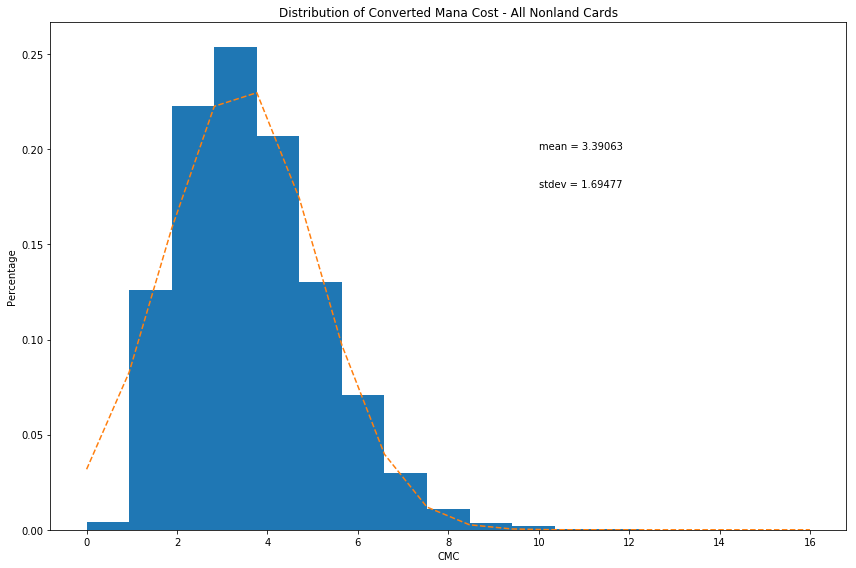

In [37]:
plot_int_hist(cmcs, title = "Distribution of Converted Mana Cost - All Nonland Cards",
              x_axis = "CMC", y_axis = "Percentage", fig_x = 12, fig_y = 8)

In [38]:
lm_pt_cmc = all_cards.loc[:, ["power", "toughness", "cmc"]]
lm_pt_cmc = lm_pt_cmc.loc[lm_pt_cmc.power.notnull() | lm_pt_cmc.toughness.notnull()]

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


Text(0.5,1,'Power/Toughness Heatmap')

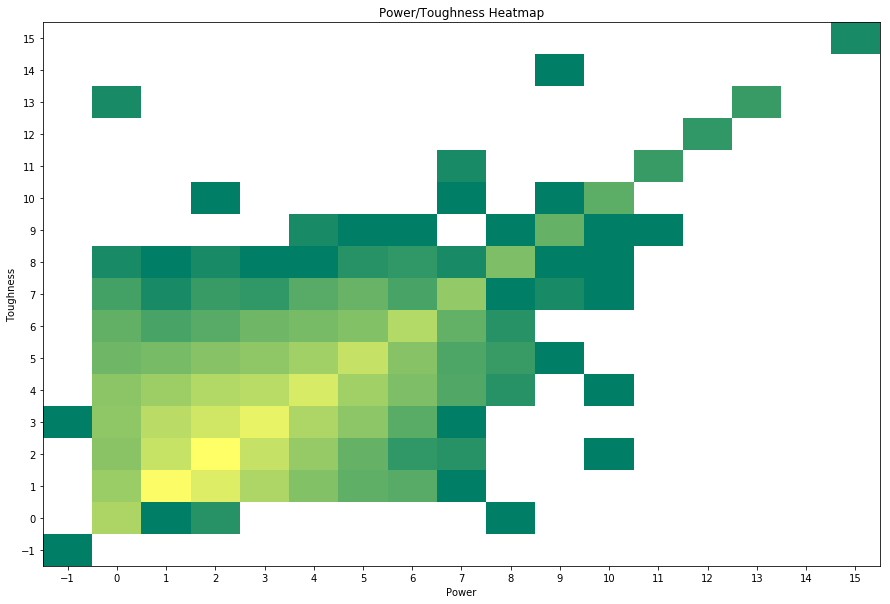

In [39]:
fig, hm = plt.subplots(figsize = (15, 10))

hm.hist2d(lm_pt_cmc.power, lm_pt_cmc.toughness, bins = np.arange(-1.5, 16.5), range = ((-1, 16), (-1, 16)), 
          cmap = "summer", norm = matplotlib.colors.LogNorm())
#hm.hexbin(lm_pt_cmc.power, lm_pt_cmc.toughness, gridsize = 17, bins = "log", cmap = "summer")
hm.set_xlabel("Power")
hm.set_ylabel("Toughness")
hm.set_xticks(np.arange(-1, 16))
hm.set_yticks(np.arange(-1, 16))
hm.set_title("Power/Toughness Heatmap")

In [40]:
avg_cmc_pivot = pd.pivot_table(data = lm_pt_cmc, values = "cmc", index = ["power", "toughness"])
avg_cmc_pivot.index

MultiIndex(levels=[[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0], [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]],
           labels=[[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 13, 14, 15], [0, 4, 1, 2, 3, 4, 5, 6, 7, 8, 9, 14, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 10, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 1, 5, 6, 7, 8, 9, 10, 6, 8, 9, 10, 11, 15, 3, 5, 8, 9, 10, 11, 10, 12, 13, 14, 16]],
           names=['power', 'toughness'])

In [41]:
len(avg_cmc_pivot)

100

In [59]:
avg_cmc_pivot.loc['power' == 13]

,cmc
toughness,
0.0,3.826087
1.0,2.341176
2.0,2.280000
3.0,2.616667
4.0,2.781818
5.0,3.000000
6.0,3.125000
7.0,3.142857
8.0,3.000000


In [56]:
lm_pt_cmc.loc[lm_pt_cmc.toughness == 13.0]

,power,toughness,cmc
name,,,
Withengar Unbound,13.0,13.0,NaN
"Emrakul, the Promised End",13.0,13.0,13.0
Tree of Perdition,0.0,13.0,4.0
Ludevic's Abomination,13.0,13.0,2.0
Tree of Redemption,0.0,13.0,4.0
Krosan Cloudscraper,13.0,13.0,10.0
Death's Shadow,13.0,13.0,1.0
